In [1]:
#sources = https://ghsl.jrc.ec.europa.eu/download.php?ds=pop
import rasterio as rio
import warnings
print(rio.__version__)

1.2.10


In [2]:
#tif_file = rasterio.open('data/GHS_POP_E2015_GLOBE_R2019A_4326_30ss_V1_0/GHS_POP_E2015_GLOBE_R2019A_4326_30ss_V1_0_MONTPELLIER.tif')
tif_file = rio.open('data/GHS_POP_E2015_GLOBE_R2019A_4326_30ss_V1_0/GHS_POP_E2015_GLOBE_R2019A_4326_30ss_V1_0_FRANCE.tif')

In [3]:
print("Tiff Boundary", tif_file.bounds)
print("Tiff CRS", tif_file.crs)
print("Tiff name", tif_file.name)
#array = tif_file.read(1)
#array.shape

Tiff Boundary BoundingBox(left=-5.508333333, bottom=42.208333333, right=11.283333333000002, top=51.416666667)
Tiff CRS EPSG:4326
Tiff name data/GHS_POP_E2015_GLOBE_R2019A_4326_30ss_V1_0/GHS_POP_E2015_GLOBE_R2019A_4326_30ss_V1_0_FRANCE.tif


In [4]:
ghs_data = tif_file.read()

In [5]:
import numpy as np

In [6]:
print("Data shape", ghs_data.shape)
print("Max value", np.amax(ghs_data))
print("Min value", np.amin(ghs_data))

Data shape (1, 1105, 2015)
Max value 26350.48602294922
Min value -200.0


In [7]:
ghs_data[0][ghs_data[0] < 0.0] = 0.0

## Plotting
**We are going to use a hot colour map.  
I want the bottom of the colourmap to be a neutral background colour so below I am taking the hot colourmap object, 460 colours from it as a list, adding a background colour to the start of that list and then building a new colourmap from that list.  
Because the background colour has been added as the first colour in the colourmap, the smallest values (0 in this case) will be mapped to that colour.**

In [8]:
from matplotlib import cm
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap, ListedColormap

ourcmap = cm.get_cmap('hot_r', 460)
newcolors = ourcmap(np.linspace(0, 1, 460))
background_colour = np.array([0.9882352941176471, 0.9647058823529412, 0.9607843137254902, 1.0])
newcolors[:1, :] = background_colour
newcmp = ListedColormap(newcolors)

**The data can then be plotted below using a log scale and the colourmap that has just been created. The data looks largely as expected however it is very messy and not particularly appealing.  
The reason for this is that humans tend to live together so there is a large population of high density values in the data as well as a large population of low density values.  
So the the high density values will be mapped to one end of the colourmap while the low density values are mapped to the other end. The result is a similar colour for all areas we might expect to show up as “populated”.**

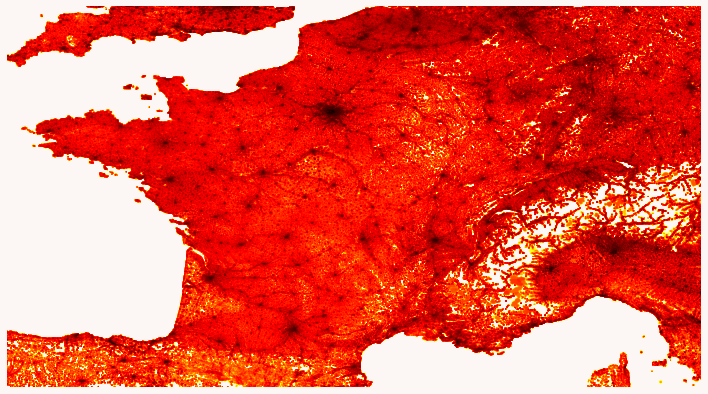

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(14, 7)
ax.imshow(ghs_data[0], norm=colors.LogNorm(), cmap=newcmp)
ax.axis('off')
warnings.filterwarnings('ignore')
plt.show()
warnings.filterwarnings('default')

**Population density maps tend to have custom scales.  
For example, one of the first results on google images uses the scale 0, 1, 5, 10, 20, 50, 100, 200, 1000 people per square kilometre so in this case they are just treating all areas with a high population as the same.  
These maps are qualitative, not quantitative because at the end of the day, we want to produce an image that is thought provoking and eye catching. Not an image that will be used to plan pandemic evacuation plans.  
So with a bit of experimentation I have settled on a slightly different set of values to map our population values to.  
Objects that use colormaps in matplotlib by default linearly map the colours in the colormap from the minimum value in the dataset to the maximum value in the dataset at discrete intervals determined by the number of colours in the colourmap.  
The BoundaryNorm class allows you to map colours in a colourmap to a set of custom values. In the code below we are creating a colourmap with 10 colours and a BoundaryNorm object which will map the values in our data to the colourmap according to the pre-defined levels.**

In [10]:
our_cmap = cm.get_cmap('hot_r', 10)
newcolors = our_cmap(np.linspace(0, 1, 10))
background_colour = np.array([0.9882352941176471, 0.9647058823529412, 0.9607843137254902, 1.0])
newcolors = np.vstack((background_colour, newcolors))
our_cmap = ListedColormap(newcolors)
bounds = [0.0, 1, 5, 10, 20, 50, 100, 200, 1000, 2000, 10000]
norm = colors.BoundaryNorm(bounds, our_cmap.N)

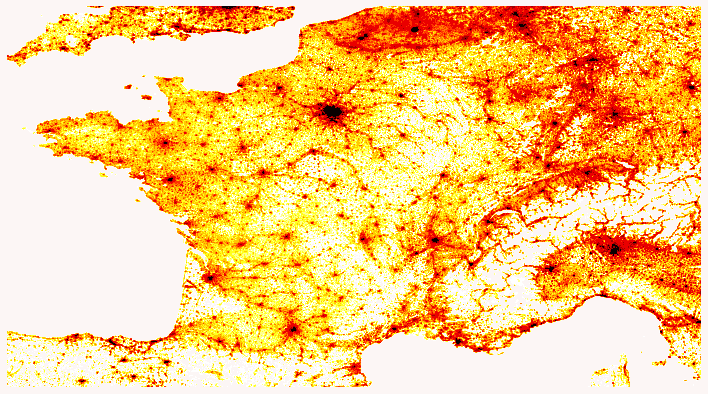

In [11]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(14, 7)
ax.imshow(ghs_data[0], norm=norm, cmap=our_cmap)
ax.axis('off')
warnings.filterwarnings('ignore')
plt.show()
warnings.filterwarnings('default')

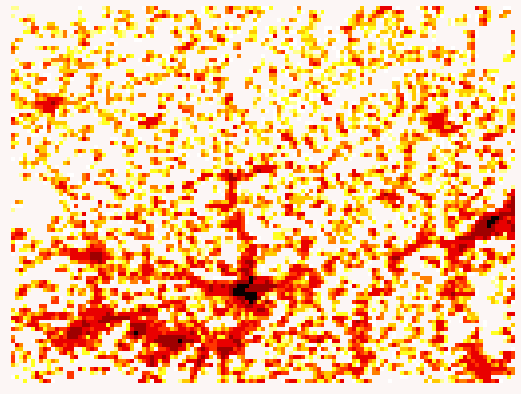

In [12]:
import rasterio.mask
import json
with open('data/luxembourg.geojson', 'r') as fp:
    shapes = json.load(fp)
    masked, out_transform = rasterio.mask.mask(tif_file, [shapes], crop=True)
    out_meta = tif_file.meta
    out_meta.update({"driver": "GTiff",
                 "height": masked.shape[1],
                 "width": masked.shape[2],
                 "transform": out_transform})
    
    with rasterio.open("output/luxembourg.byte.masked.tif", "w", **out_meta) as dest:
        dest.write(masked)
        dest.close()
        tif_file_luxembourg = rasterio.open('output/luxembourg.byte.masked.tif')
        ghs_data_luxembourg = tif_file_luxembourg.read()
        
        our_cmap = cm.get_cmap('hot_r', 10)
        newcolors = our_cmap(np.linspace(0, 1, 10))
        background_colour = np.array([0.9882352941176471, 0.9647058823529412, 0.9607843137254902, 1.0])
        newcolors = np.vstack((background_colour, newcolors))
        our_cmap = ListedColormap(newcolors)
        bounds = [0.0, 1, 5, 10, 20, 50, 100, 200, 1000, 2000, 10000]
        norm = colors.BoundaryNorm(bounds, our_cmap.N)

        fig, ax = plt.subplots(facecolor='#FCF6F5FF')
        fig.set_size_inches(14, 7)
        ax.imshow(ghs_data_luxembourg[0], norm=norm, cmap=our_cmap)
        ax.axis('off')
        warnings.filterwarnings('ignore')
        plt.show()
        warnings.filterwarnings('default')

In [13]:
#https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/
import shapely
print(shapely.__version__)
import shapely.geos
import geopandas as gpd
import pandas as pd

1.8.0


In [14]:
df = gpd.read_file('data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
western_europe = df.loc[df['ADMIN'].isin(['United Kingdom', 'Germany', 'Austria', 'Czechia',
                                              'Italy', 'Denmark', 'Luxembourg',
                                              'Belgium', 'Switzerland', 'Ireland'])]
warnings.filterwarnings('ignore')

france = df.loc[df['ADMIN'] == 'France']
Polygons = list(france.iloc[0].geometry)
france.geometry = [Polygons[1]]

spain = df.loc[df['ADMIN'] == 'Spain']
Polygons = list(spain.iloc[0].geometry)
spain.geometry = [Polygons[2]]

netherlands = df.loc[df['ADMIN'] == 'Netherlands']
Polygons = list(netherlands.iloc[0].geometry)
netherlands.geometry = [Polygons[0]]


portugal = df.loc[df['ADMIN'] == 'Portugal']
Polygons = list(portugal.iloc[0].geometry)
portugal.geometry = [Polygons[0]]

warnings.filterwarnings('default')

western_europe = pd.concat([western_europe, france, spain, netherlands, portugal])

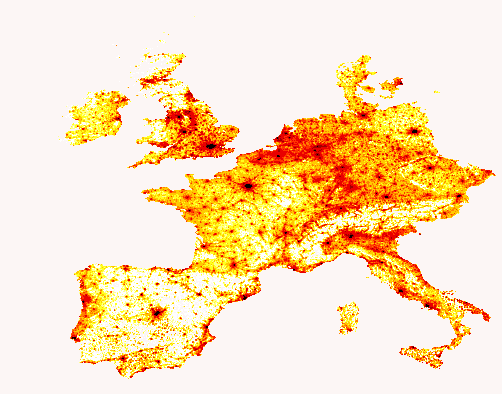

In [15]:
from shapely.geometry import mapping
from rasterio import mask as msk
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap, ListedColormap
from matplotlib import cm
import numpy as np

tif_file_world = rio.open('data/GHS_POP_E2015_GLOBE_R2019A_4326_30ss_V1_0/GHS_POP_E2015_GLOBE_R2019A_4326_30ss_V1_0.tif')
europe_array, clipped_transform = msk.mask(tif_file_world, [mapping(geom) for geom in western_europe.geometry.tolist()], crop=True)

our_cmap = cm.get_cmap('hot_r', 10)
newcolors = our_cmap(np.linspace(0, 1, 10))
background_colour = np.array([0.9882352941176471, 0.9647058823529412, 0.9607843137254902, 1.0])
newcolors = np.vstack((background_colour, newcolors))
our_cmap = ListedColormap(newcolors)
bounds = [0.0, 1, 5, 10, 20, 50, 100, 200, 1000, 2000, 10000]
norm = colors.BoundaryNorm(bounds, our_cmap.N)

fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(14, 7)
ax.imshow(europe_array[0], norm=norm, cmap=our_cmap)
ax.axis('off')
warnings.filterwarnings('ignore')
plt.show()
warnings.filterwarnings('default')

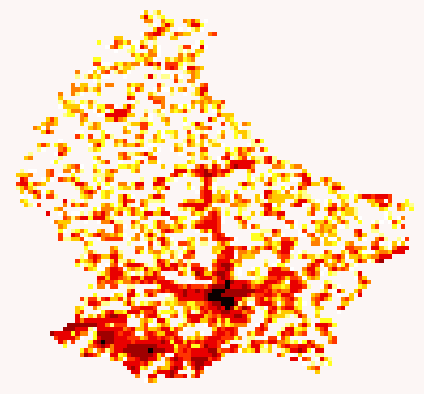

In [16]:
warnings.filterwarnings('ignore')
luxembourg = df.loc[df['ADMIN'] == 'Luxembourg']
Polygons = list(luxembourg.geometry)
luxembourg.geometry = [Polygons[0]]
warnings.filterwarnings('default')

from shapely.geometry import mapping
from rasterio import mask as msk
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap, ListedColormap
from matplotlib import cm
import numpy as np

tif_file_world = rio.open('data/GHS_POP_E2015_GLOBE_R2019A_4326_30ss_V1_0/GHS_POP_E2015_GLOBE_R2019A_4326_30ss_V1_0.tif')
europe_array, clipped_transform = msk.mask(tif_file_world, [mapping(geom) for geom in luxembourg.geometry.tolist()], crop=True)

our_cmap = cm.get_cmap('hot_r', 10)
newcolors = our_cmap(np.linspace(0, 1, 10))
background_colour = np.array([0.9882352941176471, 0.9647058823529412, 0.9607843137254902, 1.0])
newcolors = np.vstack((background_colour, newcolors))
our_cmap = ListedColormap(newcolors)
bounds = [0.0, 1, 5, 10, 20, 50, 100, 200, 1000, 2000, 10000]
norm = colors.BoundaryNorm(bounds, our_cmap.N)

fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(14, 7)
ax.imshow(europe_array[0], norm=norm, cmap=our_cmap)
ax.axis('off')
warnings.filterwarnings('ignore')
plt.show()
warnings.filterwarnings('default')